# **CNN & MNIST**

Nous allons utiliser PyTorch pour créer un modèle CNN étape par étape. Ensuite, nous allons entraîner le modèle avec les données d'entraînement et évaluer le modèle avec les données de test.

**Importation des bibliothèques**

In [1]:
import torch
import numpy as np

**Vérifier le périphérique disponible**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Résultat: `cuda` ou `cpu` selon la disponibilité du matériel GPU.

**Téléchargement de l'ensemble de données MNIST**

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.FashionMNIST(root='data', train=True, transform=ToTensor(), download=True)
test_data = datasets.FashionMNIST(root='data', train=False, transform=ToTensor())

100%|██████████| 26421880/26421880 [00:14<00:00, 1832060.12it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 59446.55it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2347629.59it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4622624.06it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Lorsque vous utilisez la fonction `datasets.MNIST` de PyTorch pour charger le jeu de données MNIST, l'argument `transform=ToTensor()` est utilisé pour spécifier la transformation à appliquer aux données chargées. En particulier, `ToTensor()` est une transformation fournie par torchvision.transforms qui convertit les images PIL en tenseurs.

Les images dans le jeu de données MNIST sont initialement fournies sous forme d'images PIL (Python Imaging Library). Cependant, pour travailler efficacement avec ces images dans le contexte de l'apprentissage automatique et des réseaux de neurones, il est souvent préférable de les convertir en tenseurs, qui sont la structure de données principale utilisée par PyTorch pour le traitement des données.

Ainsi, en utilisant `transform=ToTensor()`, vous indiquez à PyTorch de convertir les images chargées en tenseurs lors du chargement du jeu de données MNIST. Cela facilite le traitement et l'entraînement des modèles de réseaux de neurones sur ces données.

**Affichage de la taille des données d'entraînement et de test**

In [4]:
print(train_data)
print(test_data)
print(train_data.data.size())
print(train_data.targets.size())

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


**Visualisation de l'ensemble de données MNIST**

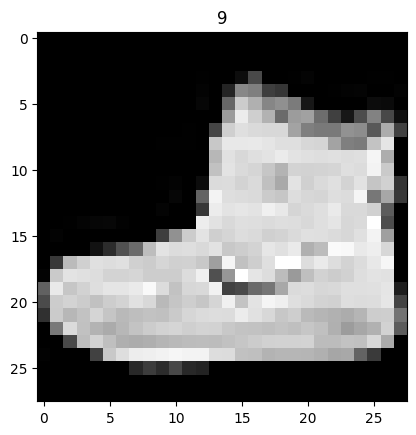

[0 1 2 3 4 5 6 7 8 9]


In [5]:
import matplotlib.pyplot as plt

# Plot d'un seul élément de données d'entraînement
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

print(np.unique(train_data.targets))

In [26]:
from PIL import Image
import numpy as np

array = np.array(train_data.data[0])
image = Image.fromarray(array)
image.save('output_image.png')

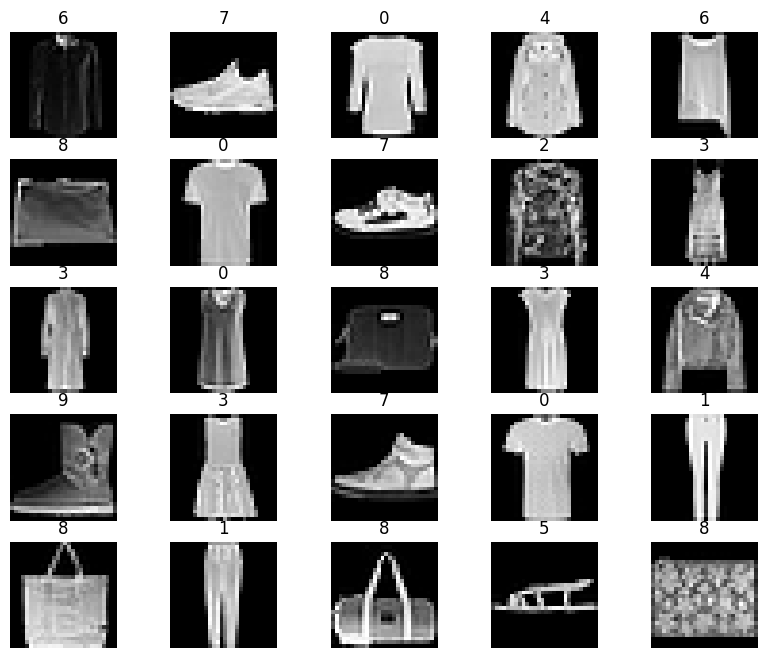

In [6]:
# Plot de plusieurs éléments de données d'entraînement
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

**Préparation des données pour l'entraînement avec DataLoaders**

In [7]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test': DataLoader(test_data, batch_size=100, shuffle=False, num_workers=1)
}

**Définition du modèle de réseau neuronal convolutif (CNN)**

Un réseau neuronal convolutif est un type de réseau neuronal utilisé principalement dans les applications de traitement d'images.

Créons un réseau neuronal convolutif en utilisant torch.nn.Module.

torch.nn.Module sera la classe de base pour tous les modules de réseau neuronal. Nous utiliserons 2 couches convolutives entièrement convolutionnelles, une fonction d'activation ReLU et un MaxPooling.

Conv2d : Applique une convolution 2D sur un signal d'entrée composé de plusieurs plans d'entrée.
Paramètres

- in_channels (int) — Nombre de canaux dans l'image d'entrée

- out_channels (int) — Nombre de canaux produits par la convolution

- kernel_size (int ou tuple) — Taille du noyau de convolution

- stride (int ou tuple, optionnel) — Pas de la convolution. Par défaut : 1

- padding (int ou tuple, optionnel) — Rembourrage de zéros ajouté des deux côtés de l'entrée. Par défaut : 0

- padding_mode (string, optionnel) — 'zeros', 'reflect', 'replicate' ou 'circular'. Par défaut : 'zeros'

- dilation (int ou tuple, optionnel) — Espacement entre les éléments du noyau. Par défaut : 1

- groups (int, optionnel) — Nombre de connexions bloquées des canaux d'entrée aux canaux de sortie. Par défaut : 1

- bias (booléen, optionnel) — Si True, ajoute un biais apprenable à la sortie. Par défaut : True

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        # output = self.out(x)
        output = F.softmax(self.out(x), dim=1)  # Ajout de la couche softmax
        return output, x


class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        output = x.view(-1, 28 * 28)  # Aplatir l'image en un vecteur
        output = torch.relu(self.fc1(output))
        output = torch.relu(self.fc2(output))
        output = self.fc3(output)
        return output, x



Cette partie de code définit la première couche du réseau neuronal convolutif (CNN) en utilisant `nn.Sequential` de PyTorch.
1. `nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)` : Cette ligne crée une couche de convolution 2D avec les paramètres suivants :
   - `in_channels=1` : Nombre de canaux dans l'image d'entrée. Dans ce cas, l'image d'entrée est en niveaux de gris, donc il y a un seul canal.
   - `out_channels=16` : Nombre de canaux de sortie, c'est-à-dire le nombre de filtres à appliquer. Cela signifie que la couche de convolution produira 16 cartes d'attributs en sortie.
   - `kernel_size=5` : Taille du noyau de convolution. Ici, un noyau de 5x5 est utilisé.
   - `stride=1` : Le pas de la convolution, c'est-à-dire le nombre de pixels dont le noyau se déplace à chaque étape.
   - `padding=2` : Le rembourrage de zéros ajouté autour de l'image d'entrée. Cela garantit que la taille de la sortie de la convolution est la même que celle de l'entrée.

2. `nn.ReLU()` : Cette ligne ajoute une fonction d'activation ReLU (Rectified Linear Unit) après la couche de convolution. La fonction ReLU applique une activation non linéaire, ce qui aide le réseau à apprendre des relations plus complexes dans les données.

3. `nn.MaxPool2d(kernel_size=2)` : Cette ligne ajoute une couche de max pooling 2D après la couche ReLU. Le max pooling réduit la dimension spatiale de l'image en prenant la valeur maximale dans chaque fenêtre de la grille spécifiée par `kernel_size=2`. Cela aide à réduire la quantité de calcul nécessaire et à rendre le modèle plus robuste aux translations dans les données d'entrée.

En résumé, cette séquence de couches crée une convolution 2D suivie d'une activation ReLU et d'un max pooling, formant ainsi la première couche du réseau CNN.


**Remarques**

Lorsque vous appliquez une convolution à une image, la taille de l'image en sortie peut être différente de celle de l'image en entrée, en fonction de plusieurs facteurs, notamment la taille du noyau de convolution et le pas (stride) de la convolution.

Le rembourrage (padding) est une technique utilisée pour contrôler la taille de l'image en sortie de la convolution. Il consiste à ajouter des zéros autour des bords de l'image d'entrée avant d'appliquer la convolution. Ces zéros ajoutés fournissent un « tampon » autour de l'image, permettant à la convolution de traiter les pixels des bords de l'image de la même manière que les pixels du centre. Cela aide à préserver les informations spatiales des bords de l'image lors de la convolution.

Dans cet exemple, `padding=2` signifie qu'un rembourrage de zéros de largeur 2 est ajouté autour de l'image d'entrée avant d'appliquer la convolution. Cela garantit que la taille de l'image en sortie de la convolution sera la même que celle de l'image d'entrée, car les deux côtés de l'image sont rembourrés avec 2 pixels de zéros de chaque côté. Ainsi, la taille de l'image en sortie reste cohérente avec celle de l'image d'entrée, ce qui facilite le traitement des images de différentes tailles dans le réseau neuronal.

La passe forward() définit la manière dont nous calculons notre sortie en utilisant les couches et fonctions données.


In [9]:
# La classe CNN comporte deux couches de convolution, chacune suivie d'une fonction d'activation ReLU et d'une opération de max pooling.
cnn = CNN()
Scnn = SimpleNN()
print(cnn)
print(Scnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
SimpleNN(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


**Définition de la fonction de perte**

In [10]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

**Définition d'une fonction d'optimisation**

In [11]:
from torch import optim

optimizer_cnn = optim.Adam(cnn.parameters(), lr=0.01)
optimizer_Scnn = optim.Adam(Scnn.parameters(), lr=0.01)


**Entraînement du modèle**

In [34]:
num_epochs = 15

def train(num_epochs, model, loaders, opt, loss_func):
    model.train()
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            output = model(images)[0]
            loss = loss_func(output, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
    return model



In [35]:
model_cnn = train(num_epochs, cnn, loaders, optimizer_cnn, loss_func)

Epoch [1/15], Step [100/600], Loss: 1.7312
Epoch [1/15], Step [200/600], Loss: 1.8509
Epoch [1/15], Step [300/600], Loss: 1.6812
Epoch [1/15], Step [400/600], Loss: 1.7411
Epoch [1/15], Step [500/600], Loss: 1.7709
Epoch [1/15], Step [600/600], Loss: 1.7412
Epoch [2/15], Step [100/600], Loss: 1.6912
Epoch [2/15], Step [200/600], Loss: 1.7711
Epoch [2/15], Step [300/600], Loss: 1.6712
Epoch [2/15], Step [400/600], Loss: 1.7612
Epoch [2/15], Step [500/600], Loss: 1.7212
Epoch [2/15], Step [600/600], Loss: 1.7512
Epoch [3/15], Step [100/600], Loss: 1.7904
Epoch [3/15], Step [200/600], Loss: 1.7312
Epoch [3/15], Step [300/600], Loss: 1.7012
Epoch [3/15], Step [400/600], Loss: 1.7312
Epoch [3/15], Step [500/600], Loss: 1.6912
Epoch [3/15], Step [600/600], Loss: 1.7511
Epoch [4/15], Step [100/600], Loss: 1.7112
Epoch [4/15], Step [200/600], Loss: 1.7312
Epoch [4/15], Step [300/600], Loss: 1.7212
Epoch [4/15], Step [400/600], Loss: 1.6512
Epoch [4/15], Step [500/600], Loss: 1.7012
Epoch [4/15

Cette approche utilise PyTorch pour créer un modèle CNN et l'entraîner étape par étape avec les données d'entraînement, tout en évaluant sa performance avec les données de test.

In [14]:
model_Scnn = train(num_epochs, Scnn, loaders, optimizer_Scnn, loss_func)

Epoch [1/10], Step [100/600], Loss: 0.5511
Epoch [1/10], Step [200/600], Loss: 0.5124
Epoch [1/10], Step [300/600], Loss: 0.5765
Epoch [1/10], Step [400/600], Loss: 0.2549
Epoch [1/10], Step [500/600], Loss: 0.7269
Epoch [1/10], Step [600/600], Loss: 0.3376
Epoch [2/10], Step [100/600], Loss: 0.4477
Epoch [2/10], Step [200/600], Loss: 0.3617
Epoch [2/10], Step [300/600], Loss: 0.4650
Epoch [2/10], Step [400/600], Loss: 0.3175
Epoch [2/10], Step [500/600], Loss: 0.4441
Epoch [2/10], Step [600/600], Loss: 0.2724
Epoch [3/10], Step [100/600], Loss: 0.4559
Epoch [3/10], Step [200/600], Loss: 0.4258
Epoch [3/10], Step [300/600], Loss: 0.3112
Epoch [3/10], Step [400/600], Loss: 0.3846
Epoch [3/10], Step [500/600], Loss: 0.2971
Epoch [3/10], Step [600/600], Loss: 0.3221
Epoch [4/10], Step [100/600], Loss: 0.2297
Epoch [4/10], Step [200/600], Loss: 0.3912
Epoch [4/10], Step [300/600], Loss: 0.3765
Epoch [4/10], Step [400/600], Loss: 0.3016
Epoch [4/10], Step [500/600], Loss: 0.3461
Epoch [4/10

**Évaluer le modèle sur les données de test**

Nous devons appeler model.eval() pour définir les couches de dropout et de normalisation par lot en mode évaluation avant de procéder à l'inférence.

model.train() indique à votre modèle que vous entraînez le modèle. Ainsi, des couches comme dropout, batchnorm, etc., qui se comportent différemment lors des procédures d'entraînement et de test, savent ce qui se passe et peuvent donc se comporter en conséquence.

Vous pouvez appeler soit model.eval() soit model.train(mode=False) pour indiquer que vous testez le modèle.


In [15]:
def test(model_nn):
    # Tester le modèle
    model_nn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = model_nn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
        print('Précision du modèle sur les 10000 images de test : %.2f' % accuracy)

    pass



In [36]:
test(model_cnn)

Précision du modèle sur les 10000 images de test : 0.73


In [16]:
test(model_Scnn)

Précision du modèle sur les 10000 images de test : 0.84


**Imprimer 10 prédictions à partir des données de test**

In [18]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

actual_number = lbls[:10].numpy()
print(f'Numéro réel : {actual_number}')

test_output, last_layer = model_cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Numéro prédit : {pred_y}')

Numéro réel : [9 2 1 1 6 1 4 6 5 7]
Numéro prédit : [9 2 1 1 2 1 2 2 5 7]


In [19]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

actual_number = lbls[:10].numpy()
print(f'Numéro réel : {actual_number}')

test_output, last_layer = model_Scnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Numéro prédit : {pred_y}')

Numéro réel : [9 2 1 1 6 1 4 6 5 7]
Numéro prédit : [9 2 1 1 6 1 4 6 5 7]


Ces instructions expliquent comment évaluer le modèle sur les données de test, affichant également la précision du modèle, puis comment imprimer 10 prédictions à partir des données de test.

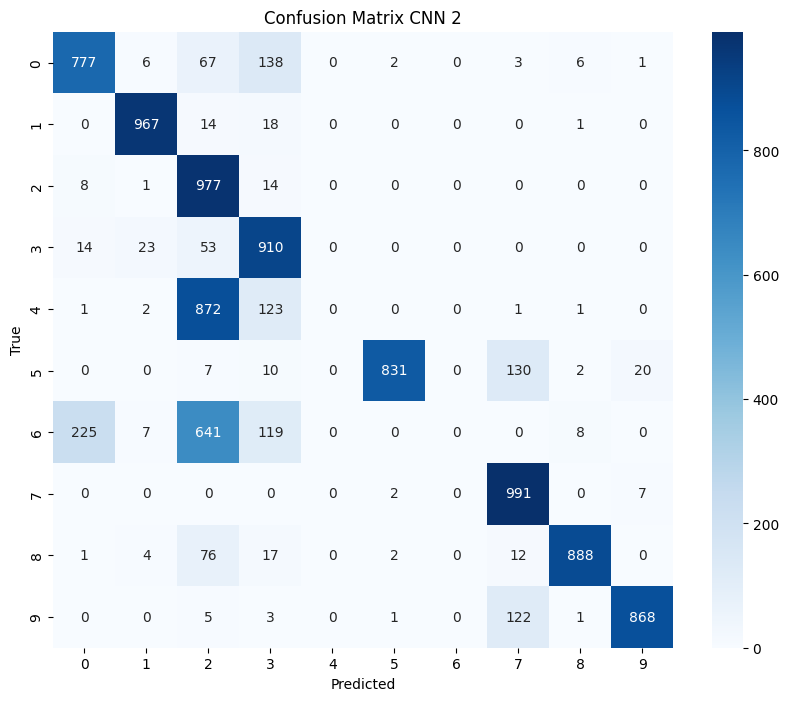

In [38]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

model = model_cnn
test_loader = loaders["test"]

# Listes pour stocker les vraies étiquettes et les prédictions
all_labels = []
all_preds = []

# Mettre le modèle en mode évaluation
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        # Envoyer les données au périphérique (CPU ou GPU)
        data, target = data.to(device), target.to(device)

        # Faire les prédictions
        outputs, _ = model(data)
        _, preds = torch.max(outputs, 1)

        # Stocker les vraies étiquettes et les prédictions
        all_labels.extend(target.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix CNN 2')

plt.show()

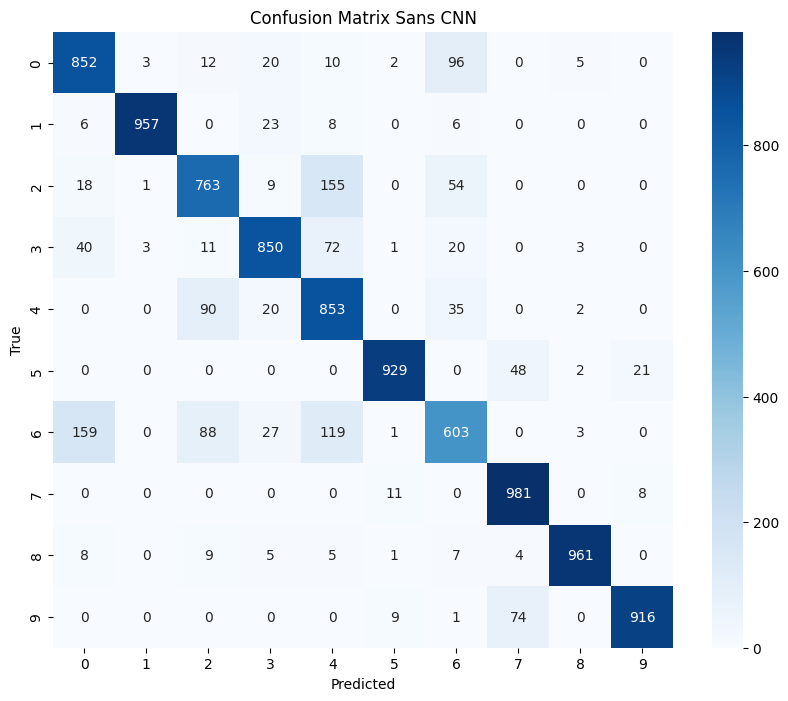

In [33]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

model = model_Scnn
test_loader = loaders["test"]

# Listes pour stocker les vraies étiquettes et les prédictions
all_labels = []
all_preds = []

# Mettre le modèle en mode évaluation
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        # Envoyer les données au périphérique (CPU ou GPU)
        data, target = data.to(device), target.to(device)

        # Faire les prédictions
        outputs, _ = model(data)
        _, preds = torch.max(outputs, 1)

        # Stocker les vraies étiquettes et les prédictions
        all_labels.extend(target.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Sans CNN')

plt.show()

## **Sauvegarder un modèle en format ONNX**
Pour sauvegarder un modèle en format ONNX dans PyTorch, vous pouvez utiliser la fonction `torch.onnx.export()`. Voici un exemple de script qui illustre comment sauvegarder un modèle en format ONNX :


In [20]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 30.2 MB/s eta 0:00:00


In [22]:
import torch
import torchvision.models as models

# Définir des données factices en entrée
dummy_input = torch.randn(1, 1, 28, 28)  # Les dimensions correspondent à celles des données MNIST

# Spécifier le chemin de sauvegarde du modèle ONNX
onnx_path = "Scnn_model.onnx"

# Exporter le modèle en format ONNX
torch.onnx.export(model_Scnn, dummy_input, onnx_path)

